In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Compose, PILToTensor, ToTensor
import PIL
import torch
import torchvision as torchvision

from dataset import CropSegmentationDataset
from am4ip.new_trainer import BaselineTrainer

from gen_model_v2 import GenerativeModel

from torch.utils.data import DataLoader

In [2]:
batch_size = 16
lr = 1e-2
epochs = 105

In [3]:
transform = Compose([lambda z: z.resize((256,256),PIL.Image.BILINEAR), 
                     PILToTensor(),
                     lambda z: z.to(dtype=torch.float32) / 127.5 - 1  # Normalize between -1 and 1
                     ])

target_transform = Compose([lambda z: z.resize((256,256),PIL.Image.NEAREST),
                            PILToTensor(),
                            lambda z : z.to(dtype=torch.int64).squeeze(0)
                     ])

In [4]:
dataset_train = CropSegmentationDataset(set_type="train", transform=transform, target_transform = target_transform, remove_small_items = True, merge_small_items=False)
dataset_val = CropSegmentationDataset(set_type="val", target_transform = target_transform, transform = transform, remove_small_items = True, merge_small_items=False)

In [61]:
generative_model = torch.load('genv3/model_5epoch.pt')

In [62]:
loss_image = torch.nn.MSELoss()
loss_segmentation = torch.nn.CrossEntropyLoss()

In [63]:
train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

optimizer = torch.optim.Adam(generative_model.parameters(), lr=0.001)

In [64]:
num_epochs = 3
l_t = len(train_loader)

In [65]:
train_loss_history = []
validation_loss_history = []
validation_accuracy_history = []

for epoch in range(epochs):
    generative_model.train()
    for i, (input_image, target_segmentation) in enumerate(train_loader):
        # Mettre à zéro les gradients
        optimizer.zero_grad()

        generated_image, generated_segmentation = generative_model(input_image)

        # Calcul loss
        loss_image = loss_image(generated_image, input_image)
        loss_segmentation = loss_segmentation(generated_segmentation, target_segmentation)
        total_loss = loss_image + loss_segmentation

        total_loss.backward()

        optimizer.step()

        print(f"\rEpoch {epoch + 1}/{epochs}, Batch {i + 1}/{l_t}, Loss: {loss_image.item()}", end='')

    average_loss = total_loss / l_t
    print(f"\rEpoch {epoch + 1}/{epochs}, Average Loss: {average_loss}")
    
    # Validation
    with torch.no_grad():
        generative_model.eval()

        validation_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for j, (val_input_image, val_target_segmentation) in enumerate(val_loader):
            val_generated_image, val_generated_segmentation = generative_model(val_input_image)

            # Calcul val loss
            val_loss_image = loss_image(val_generated_image, val_input_image)
            val_loss_segmentation = loss_segmentation(val_generated_segmentation, val_target_segmentation)
            total_val_loss = val_loss_image + val_loss_segmentation

            validation_loss += total_val_loss.item()

            _, predicted_labels = torch.max(val_generated_segmentation, 1)
            correct_predictions += (predicted_labels == val_target_segmentation).sum().item()
            total_samples += val_target_segmentation.numel()

        average_validation_loss = validation_loss / len(val_loader)

        validation_accuracy = correct_predictions / total_samples

        print(f"Validation Loss: {average_validation_loss}, Validation Accuracy: {validation_accuracy}")

    train_loss_history.append(total_loss.item())
    validation_loss_history.append(validation_loss)
    validation_accuracy_history.append(validation_accuracy)

    # Sauvegarde du modèle toutes les 5 époques
    if (epoch + 1) % 5 == 0:
        name_model = 'modeles/genv4/' + str(epoch+1+70) + 'epoch.pt'
        torch.save(generative_model, name_model)

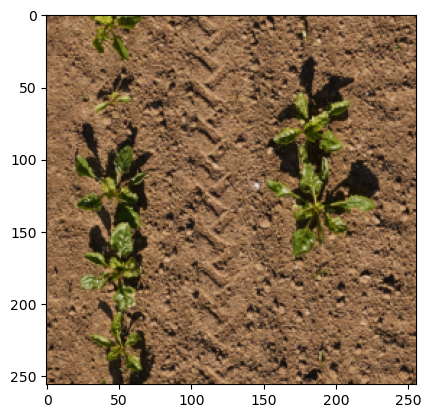

In [66]:
t0 = dataset_val[16] #dataset_train[840]
i_drone = (t0[0].permute(1,2,0)+1) * 0.5
plt.imshow(i_drone)

In [67]:
generative_model.eval()

with torch.no_grad():
    generated_image, generated_segmentation = generative_model(t0[0].unsqueeze(0))

In [68]:
# Tenseurs -> images
to_pil_image = transforms.ToPILImage()
generated_image_pil = to_pil_image(generated_image.squeeze().cpu())

In [69]:
test = generated_segmentation.cpu().detach()
test1 = test.squeeze(0)
i = torch.softmax(test1, 0)

i_merged = torch.stack([i[0], i[1], i[2]])
i_result = torch.argmax(i_merged, dim=0)

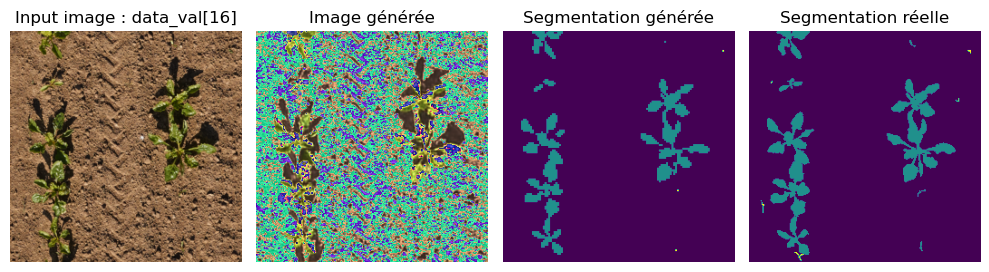

In [70]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))  
axes[0].imshow(i_drone)
axes[0].set_title('Input image : data_val[16]')
axes[0].axis('off')
axes[1].imshow(generated_image_pil)
axes[1].set_title('Image générée')
axes[1].axis('off')
axes[2].imshow(i_result)
axes[2].set_title('Segmentation générée')
axes[2].axis('off')
axes[3].imshow(t0[1])
axes[3].set_title('Segmentation réelle')
axes[3].axis('off')

plt.tight_layout()
plt.savefig('result_gen_data_5_epoch_2.png')
plt.show()